## 라이브러리 가져오기

In [1]:
import matplotlib.animation as animation
import matplotlib.pyplot as plt
import numpy as np

from tqdm.auto import tqdm
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

## 데이터셋 불러오기

In [2]:
data = np.loadtxt('data.txt')
data = ((data - data.mean(axis=0)) / data.std(axis=0)) * 5

data.shape

(4100, 2)

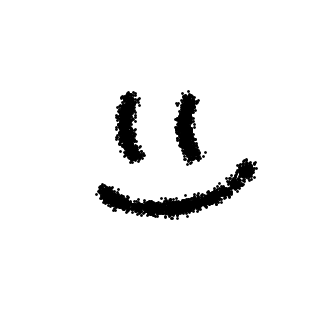

In [3]:
plt.figure(figsize=(4, 4))
plt.scatter(data[:, 0], data[:, 1], c='black', s=1)
plt.xlim(-20, 20)
plt.ylim(-20, 20)
plt.axis('off')
plt.show()

## 학습용 데이터로 만들기

In [4]:
X = torch.tensor(data, dtype=torch.float32)
X.shape

torch.Size([4100, 2])

## Hyperparameters for Diffusion Model

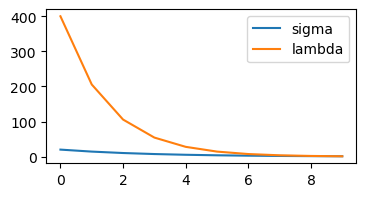

In [5]:
T = 20
L = 10
eps = 0.1

sigmas = [20 * ((1/20) ** (1/9))**i for i in range(L)]
sigmas = torch.tensor(sigmas, dtype=torch.float32)

lambdas = [i**2 for i in sigmas]
lambdas = torch.tensor(lambdas, dtype=torch.float32)

plt.figure(figsize=(4, 2))
plt.plot(sigmas, label='sigma')
plt.plot(lambdas, label='lambda')
plt.legend()
plt.show()

## NCSN 모델

In [6]:
class NCSN(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(2+1, 128),
            nn.Softplus(),
            nn.Linear(128, 128),
            nn.Softplus(),
            nn.Linear(128, 2)
        )
    
    def forward(self, x, sigma):
        sigma = sigma.unsqueeze(0).repeat(x.shape[0], 1)
        x = torch.hstack([x, sigma])
        return self.net(x)

In [7]:
model = NCSN()

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

optimizer = optim.Adam(model.parameters(), lr=1e-3)

model

NCSN(
  (net): Sequential(
    (0): Linear(in_features=3, out_features=128, bias=True)
    (1): Softplus(beta=1.0, threshold=20.0)
    (2): Linear(in_features=128, out_features=128, bias=True)
    (3): Softplus(beta=1.0, threshold=20.0)
    (4): Linear(in_features=128, out_features=2, bias=True)
  )
)

## Training

In [8]:
epochs = 10000
batch_size = 128

loss_fn = nn.MSELoss()

pbar = tqdm(range(epochs), total=epochs, leave=False)

for epoch in pbar:
    epoch_loss = steps = 0

    for i in range(0, len(X), batch_size):
        X_batch = X[i:i+batch_size].to(device)

        ls = []

        for t in range(L):
            noise = torch.randn_like(X_batch) * sigmas[t]

            x_tilde = X_batch + noise

            model_result = model(x_tilde.to(device), sigmas[t].to(device))

            loss = loss_fn(model_result, (X_batch - x_tilde) / sigmas[t]**2)
            ls.append(loss * lambdas[t])

        total_loss = sum(ls) / L

        optimizer.zero_grad()
        total_loss.backward()
        optimizer.step()

        epoch_loss += total_loss.item()
        steps += 1
    
    pbar.set_description(f'Loss: {epoch_loss/steps:.4f}')

    pbar.update(1)

pbar.close()


  0%|          | 0/1000 [00:00<?, ?it/s]

## Sampling

In [9]:
x_tilde = torch.randn(6000, 2).to(device)
x_tilde_history = [x_tilde]

for i in range(L):
    alpha_i = eps * sigmas[i]**2/sigmas[-1]**2
    
    for t in range(T):
        z_t = torch.randn_like(x_tilde)
        
        x_tilde = x_tilde + alpha_i/2 * model(x_tilde, sigmas[i].to(device)) + np.sqrt(alpha_i) * z_t
        x_tilde_history.append(x_tilde)
    
    x_tilde = x_tilde.detach()

MovieWriter imagemagick unavailable; using Pillow instead.


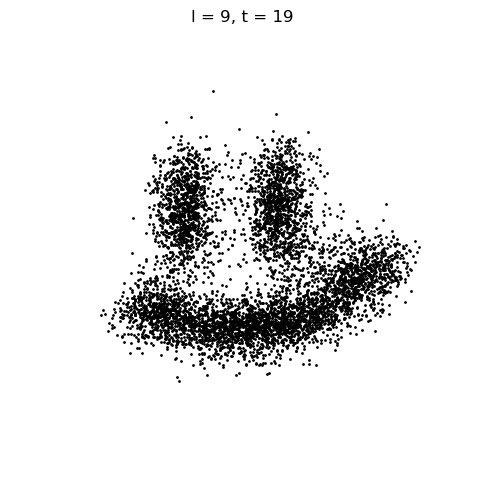

In [10]:
fig, ax = plt.subplots(figsize=(6, 6))

def draw_frame(i):
    ax.clear()
    Xvis = x_tilde_history[i].detach().cpu().numpy()
    fig = ax.scatter(Xvis[:, 0], Xvis[:, 1], c='black', s=1, animated=True)
    ax.set_xlim(-20, 20)
    ax.set_ylim(-20, 20)
    ax.axis('off')
    ax.set_title(f'l = {i // T}, t = {i % T}')
    return fig,


frames = list(range(T*L)) + [T*L-1] * 100

anim = animation.FuncAnimation(fig, draw_frame, frames=frames, interval=50, blit=True)

anim.save('NCSN_sampling.gif', writer='imagemagick', fps=20)